In [25]:
import os

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["monospace"]
plt.rcParams["pdf.use14corefonts"] = True
from networkx.generators import triangular_lattice_graph
import numpy as np

from scipy.optimize import curve_fit
import h5py

In [2]:
markers = ('s', 'x', '.', "^")
colors = ["red", "orangered", "forestgreen", "darkorchid"]
datadirs = ["row/A=N", "row/A=Ng", "2rows", "triang"]
labels = ["Ladder(Uniform)", "Ladder(Gaussian)", "Double Ladder", "Triangular Row"]
m = [4, 5, 7, 5]

[0.32838296 0.50135224 0.22201384 0.00726245]
[0.91395724 1.16391598 0.13201174 0.0203845 ]
[1.22868405 0.85021884 0.14874977 0.02549   ]
[3.29629059 0.98156199 2.12930727 0.98156593]


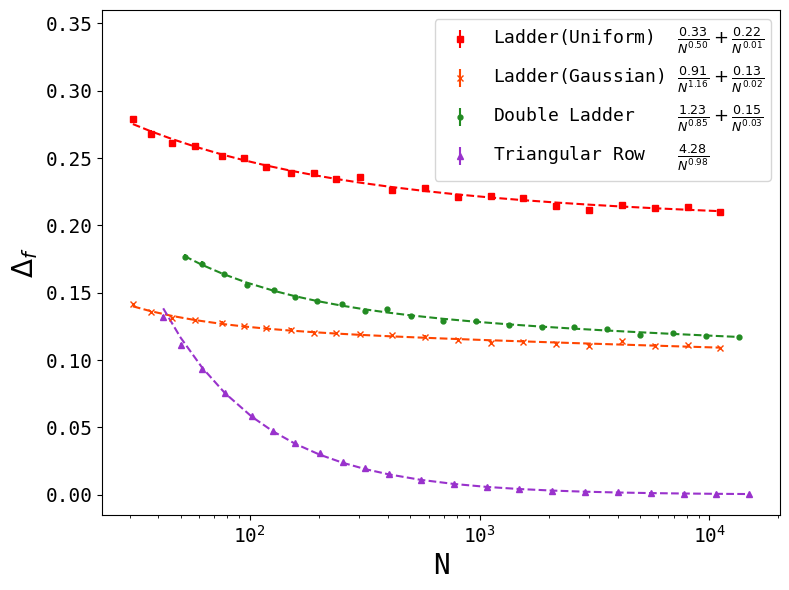

In [163]:
plt.figure(figsize=(8,6))

f_fit = lambda x, a, b, c, d: a / x**b + c / x**d
i = 0

for datadir in datadirs:
    if "A=N" in datadir:
        N = [3*ns+1 for ns in np.unique(np.logspace(1, np.log10(100), 11)[:-1].astype(int))]
    if datadir == "2rows":
        N = [5*ns + 2 for ns in np.unique(np.logspace(1, np.log10(100), 11)[:-1].astype(int))]
    if datadir == "triang":
        N = list(np.zeros(10))
        for j, n in enumerate(np.unique(np.logspace(1, np.log10(100), 11)[:-1].astype(int))):
            G = triangular_lattice_graph(1, n)
            N[j] = G.number_of_edges()*2

    delta_f = np.load(f"data/{datadir}/deltaF_plot.npy")
    
    if "A=Ng" in datadir:
        df = np.load(f"data/row/rowG.npy")
    elif "A=N" in datadir:
        df = np.load(f"data/row/row.npy")
        df[:, 1] = df[:, 1] - [i*0.0005 for i, _ in enumerate(df[:, 0])]
    else:
        df = np.load(f"data/{datadir}/{datadir}.npy")

    N = np.array(N + list(df[:, 0]))
    df = np.vstack((delta_f, df[:, 1:3]))

    popt, pcov = curve_fit(f_fit, N, df[:, 0], sigma=df[:, 1], p0=[0.8, 0.9, 0.2, 0.02], maxfev=10000,
                       bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))

    print(popt)

    label = f"{labels[i]:16} $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}}}} + \\frac{{{popt[2]:.2f}}}{{N^{{{popt[3]:.2f}}}}}$"
    if datadir == "triang":
        label = f"{labels[i]:16} $\\frac{{{popt[0]+popt[3]:.2f}}}{{N^{{{popt[1]:.2f}}}}}$"
    plt.errorbar(N, df[:, 0], yerr=df[:, 1], ms=m[i], fmt=markers[i], label=label, color=colors[i])

    plt.plot(N, f_fit(N, *popt), c=colors[i], ls="--")
    
    i += 1

plt.xscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("N", fontsize=20)
plt.ylabel("$\Delta_f$", fontsize=20)

plt.ylim([-0.015, 0.36])

plt.legend(prop={'size': 13})
# plt.yscale("log")
plt.tight_layout()
plt.savefig("plots/df.pdf", bbox_inches="tight")

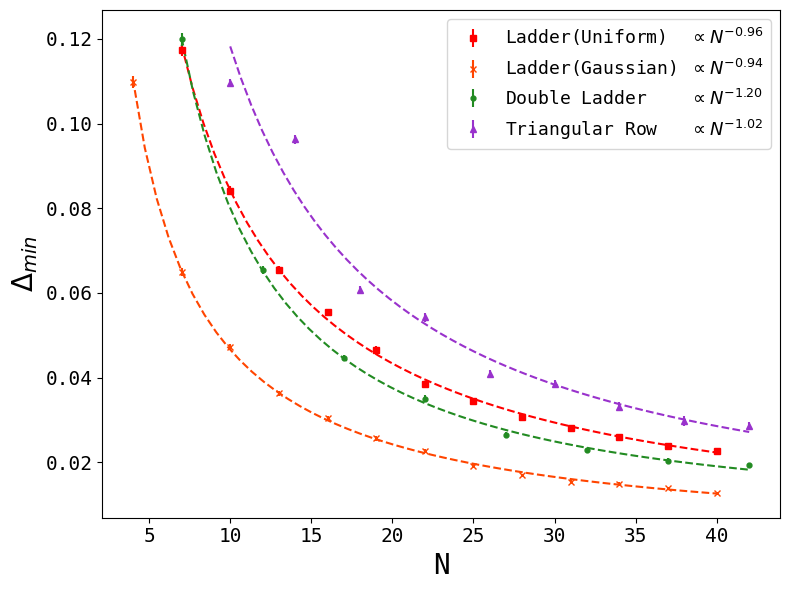

In [198]:
f_fit = lambda x, a, b, c: a / x**b + c

plt.figure(figsize=(8,6))

for i, datadir in enumerate(datadirs):
    N = np.load(f"data/{datadir}/N.npy")
    dmin = np.load(f"data/{datadir}/dmin.npy")

    if datadir == "row/A=N":
        N = N[1:]
        dmin = dmin[1:, :]

    popt, pcov = curve_fit(f_fit, N, dmin[:, 0], sigma=dmin[:, 1], p0=[0.3, 0.05, 0.8],
                           absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    if datadir == "triang":
        popt, pcov = curve_fit(f_fit, N, dmin[:, 0], p0=[0.3, 0.5, 0.8], 
                               bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
                               sigma=[1/(i+1)**0.5 for i, _ in enumerate(N)])
        
    label = f"{labels[i]:16} $\\propto N^{{-{popt[1]:.2f}}}$"
    plt.errorbar(N, dmin[:, 0], yerr=dmin[:, 1], ms=m[i], label=label, 
                 fmt=markers[i], c=colors[i])

    N = np.linspace(N[0], N[-1])
    plt.plot(N, f_fit(N, *popt), c=colors[i], ls="--")

    # print(np.sqrt(np.diag(pcov)))
    # print("\n")

plt.legend(prop={'size': 13})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("N", fontsize=20)
plt.ylabel("$\Delta_{min}$", fontsize=20)

plt.tight_layout()
plt.savefig("plots/dmin.pdf", bbox_inches="tight")

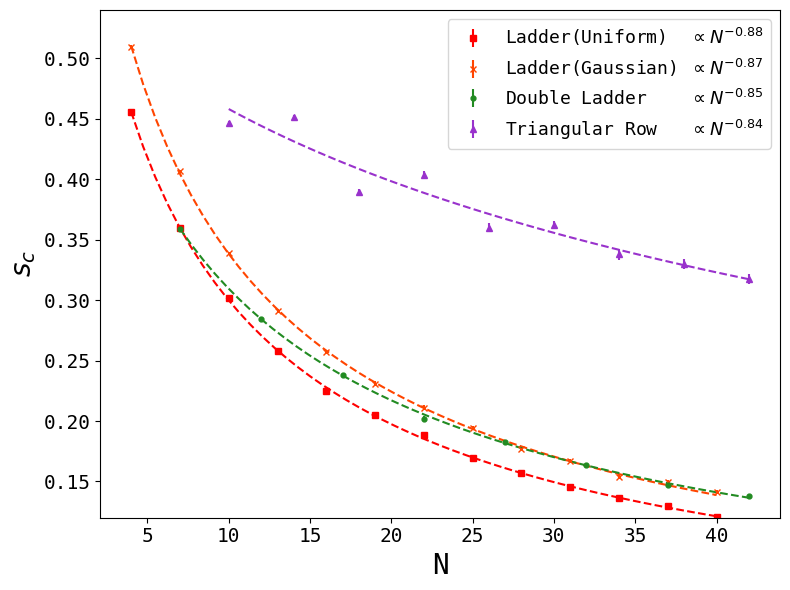

In [197]:
f_fit = lambda x, a, b, c: a / (x**b + c)

plt.figure(figsize=(8,6))

for i, datadir in enumerate(datadirs):
    N = np.load(f"data/{datadir}/N.npy")
    sc = np.load(f"data/{datadir}/sc.npy")

    popt, pcov = curve_fit(f_fit, N, sc[:, 0], sigma=sc[:, 1], p0=[0.1, 0.8, 0.1],
                           absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    if datadir == "triang":
        popt, pcov = curve_fit(f_fit, N, sc[:, 0], p0=[0.3, 0.5, 0.1], 
                               bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
                               sigma=[1/(i+1)**0.5 for i, _ in enumerate(N)])

    label = f"{labels[i]:16} $\\propto N^{{-{popt[1]:.2f}}}$"
    plt.errorbar(N, sc[:, 0], yerr=sc[:, 1], label=label,
                 ms=m[i], fmt=markers[i], c=colors[i])

    N = np.linspace(N[0], N[-1])
    plt.plot(N, f_fit(N, *popt), c=colors[i], ls="--")

    # print(popt)
    # print(np.sqrt(np.diag(pcov)))
    # print("\n")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim([0.12, 0.54])

plt.legend(prop={'size': 13})

plt.xlabel("N", fontsize=20)
plt.ylabel("$s_c$", fontsize=20)

plt.tight_layout()
plt.savefig("plots/sc.pdf", bbox_inches="tight")

[ 0.12512482  0.51393008 -0.00950902]
[0.00957819 0.08632996 0.00494194]


[ 0.10057902  0.66549422 -0.00255654]
[0.00879028 0.07010513 0.00166585]


[0.24854293 0.98118323 0.00357051]
[0.06324217 0.14326004 0.00213847]


[ 0.26009264  0.63698545 -0.00258149]
[0.23807182 0.60054377 0.03355107]




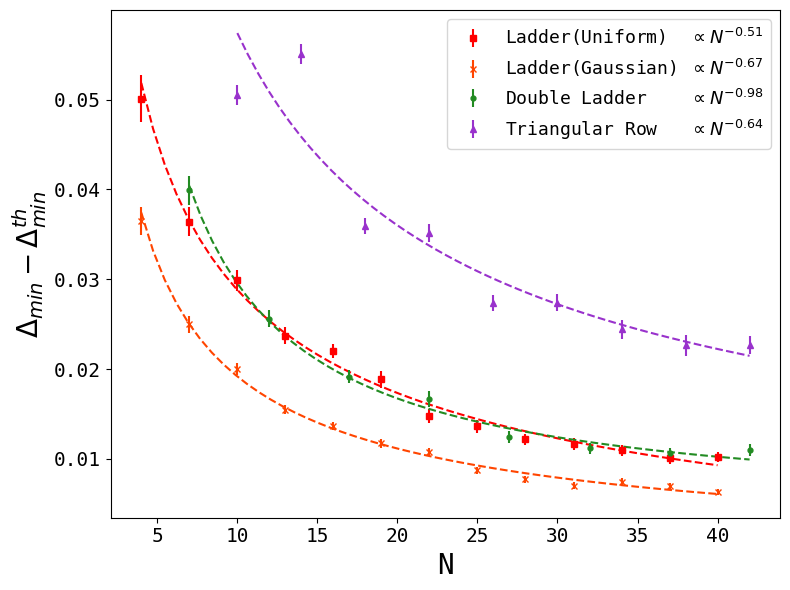

In [199]:
f_fit = lambda x, a, b, c: a / x**b + c

plt.figure(figsize=(8,6))

for i, datadir in enumerate(datadirs):
    N = np.load(f"data/{datadir}/N.npy")
    ddmin = np.load(f"data/{datadir}/ddmin.npy")

    popt, pcov = curve_fit(f_fit, N, ddmin[:, 0], sigma=ddmin[:, 1], 
                           p0=[0.3, 0.5, 0.1], absolute_sigma=True)

    if datadir == "triang":
        popt, pcov = curve_fit(f_fit, N, ddmin[:, 0], p0=[0.3, 0.5, 0.1], 
                               sigma=[1/(i+1)**0.5 for i, _ in enumerate(N)])

    label = f"{labels[i]:16} $\\propto N^{{-{popt[1]:.2f}}}$"
    plt.errorbar(N, ddmin[:, 0], yerr=ddmin[:, 1], label=label,
                 ms=m[i], fmt=markers[i], c=colors[i])

    N = np.linspace(N[0], N[-1])
    plt.plot(N, f_fit(N, *popt), c=colors[i], ls="--")

    print(popt)
    print(np.sqrt(np.diag(pcov)))
    print("\n")

plt.legend(prop={'size': 13})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("N", fontsize=20)
plt.ylabel("$\Delta_{min} - \Delta_{min}^{th}$", fontsize=20)

plt.tight_layout()
plt.savefig("plots/ddmin.pdf", bbox_inches="tight")

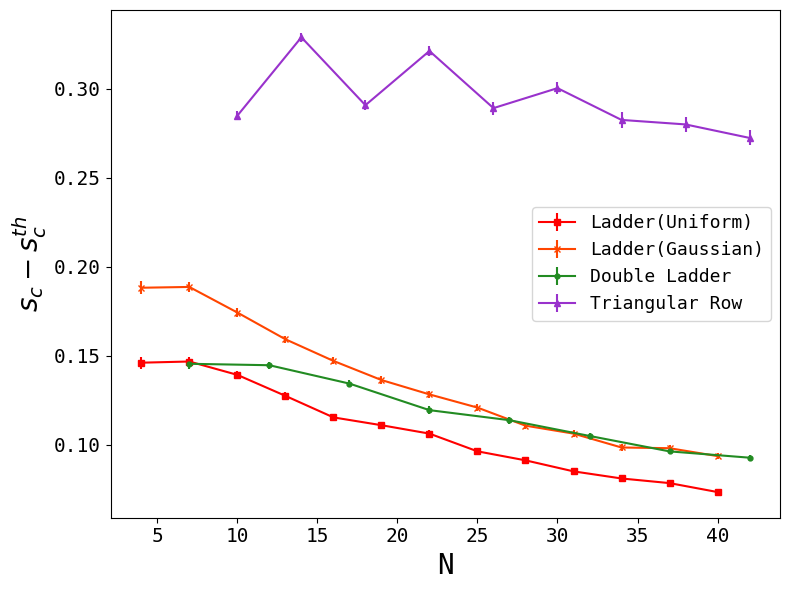

In [182]:
f_fit = lambda x, a, b, c: a / x**b + c

plt.figure(figsize=(8,6))

for i, datadir in enumerate(datadirs):
    N = np.load(f"data/{datadir}/N.npy")
    dsc = np.load(f"data/{datadir}/dsc.npy")
    
    plt.errorbar(N, dsc[:, 0], yerr=dsc[:, 1], label=labels[i],
                 ms=m[i], fmt=markers[i]+"-", c=colors[i])

    # popt, pcov = curve_fit(f_fit, N, dsc[:, 0], sigma=dsc[:, 1], p0=[0.3, 0.05, 0.8],
    #                        absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    # N = np.linspace(N[0], N[-1])
    # plt.plot(N, f_fit(N, *popt), c=colors[i], ls="--")

    # print(popt)
    # print(np.sqrt(np.diag(pcov)))
    # print("\n")

plt.legend(prop={'size': 13})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("N", fontsize=20)
plt.ylabel("$s_c - s_c^{th}$", fontsize=20)
plt.tight_layout()
plt.savefig("plots/dsc.pdf", bbox_inches="tight")

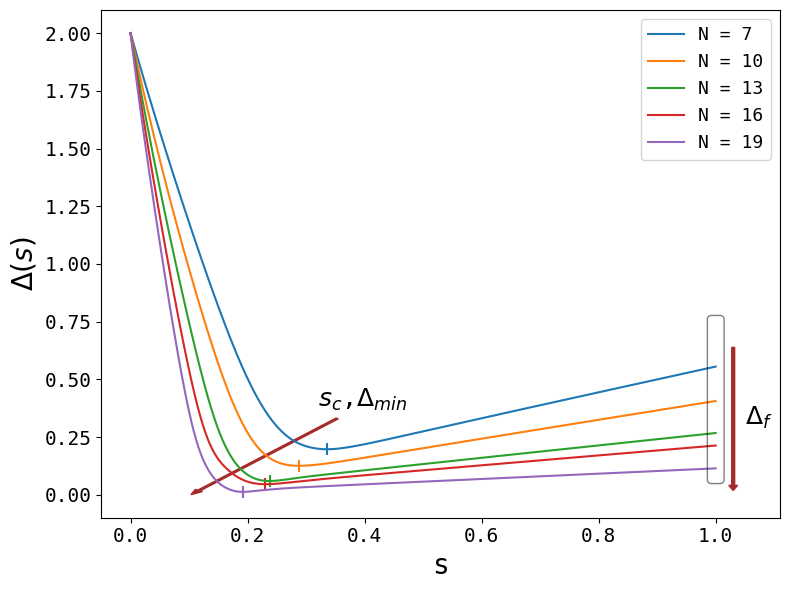

In [176]:
plt.figure(figsize=(8,6))

cs = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
for i, ns in enumerate([2, 3, 4, 5, 6]):
    f = h5py.File(f"data/ex/ns{ns}.jld", "r")
    S, D = np.array(f["S"]), np.array(f["D"])
    N, df = int(np.array(f["N"])), float(np.array(f["df"]))

    plt.plot(S, D, label=f"N = {N}", c=cs[i])
    plt.scatter([S[np.argmin(D)]], [D[np.argmin(D)]], marker="|", c=cs[i], s=80)

    # sc_ind = np.argmin(np.abs(2 - (N+2)*S - df*S))  
    # plt.plot(S[:sc_ind+3], 2 - (N+2)*S[:sc_ind+3], label=f"N = {N}", c=cs[i])
    # plt.plot(S[sc_ind-10:], df*S[sc_ind-10:], c=cs[i])

    # plt.scatter([S[sc_ind]], [df*S[sc_ind]], c=cs[i], s=20)

plt.legend(prop={'size': 13})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.ylabel("$\\Delta(s)$", fontsize=20)

plt.arrow(0.36, 0.34, -0.25, -0.33, length_includes_head=True, head_width=0.015, width=0.005, 
          head_starts_at_zero=True, aa=True, color="brown")

plt.arrow(1.03, 0.65, 0, -0.62, length_includes_head=True, head_width=0.015, width=0.005, 
          head_starts_at_zero=True, aa=True, color="brown")

plt.text(0.993, .08, 9*" \n", 
         bbox=dict(boxstyle="round", fill=None, ec="k", alpha=0.5))

plt.text(0.32, 0.38, "$s_c$,$\Delta_{min}$", fontsize=18)
plt.text(1.05, 0.39, "$\Delta_f$", fontsize=18,
        verticalalignment='top', bbox=dict(boxstyle='round', alpha=0))
    
plt.xlim([-0.05, 1.11])
plt.tight_layout()
plt.savefig("plots/Ds_with_N.pdf", bbox_inches="tight")

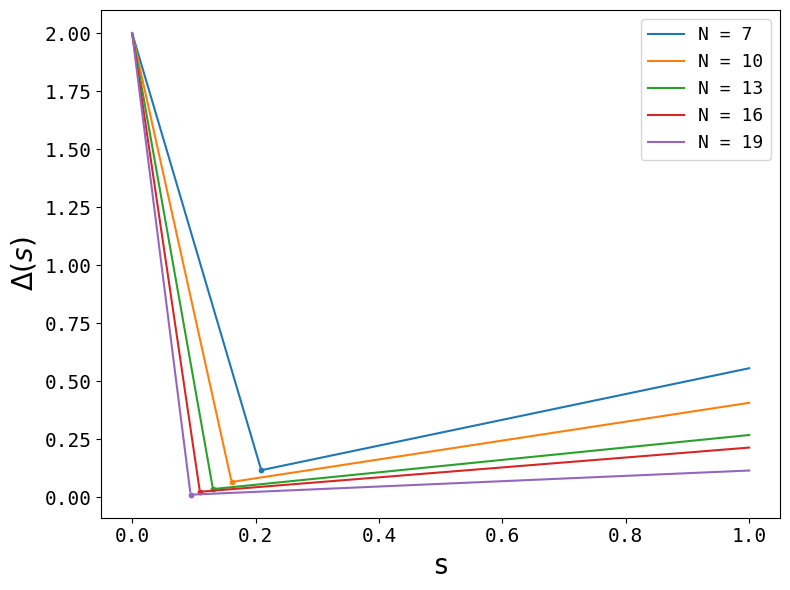

In [196]:
plt.figure(figsize=(8,6))

cs = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
for i, ns in enumerate([2, 3, 4, 5, 6]):
    f = h5py.File(f"data/ex/ns{ns}.jld", "r")
    S, D = np.array(f["S"]), np.array(f["D"])
    N, df = int(np.array(f["N"])), float(np.array(f["df"]))

    S = np.linspace(0, 1, 1000)
    sc_ind = np.argmin(np.abs(2 - (N+2)*S - df*S))
    plt.plot(S[:sc_ind], 2 - (N+2)*S[:sc_ind], label=f"N = {N}", c=cs[i])
    plt.plot(S[sc_ind:], df*S[sc_ind:], c=cs[i])

    plt.scatter([S[sc_ind]], [df*S[sc_ind]], c=cs[i], s=10)

plt.legend(prop={'size': 13})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.ylabel("$\\Delta(s)$", fontsize=20)

plt.tight_layout()
plt.savefig("plots/Ds_th.pdf", bbox_inches="tight")

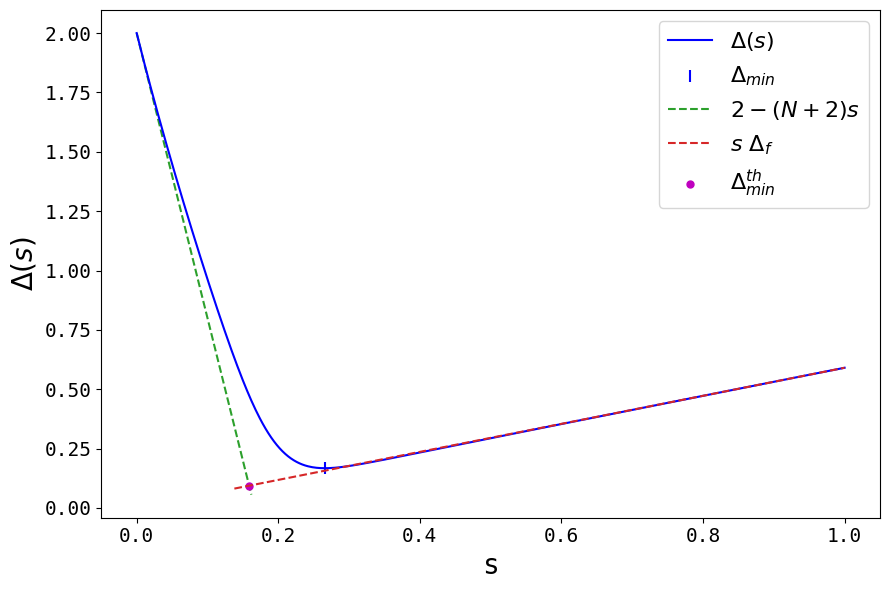

In [177]:
plt.figure(figsize=(9,6))

ns = 3
f = h5py.File(f"data/ex/gap.jld", "r")

S, D = np.array(f["S"]), np.array(f["D"])
N, df = int(np.array(f["N"])), float(np.array(f["df"]))

plt.plot(S, D, c="blue", label="$\Delta(s)$")
plt.scatter([S[np.argmin(D)]], [D[np.argmin(D)]], marker="|", c="blue", s=85, label="$\Delta_{min}$")

sc_ind = np.argmin(np.abs(2 - (N+2)*S - df*S))  
plt.plot(S[:sc_ind+3], 2 - (N+2)*S[:sc_ind+3], c="tab:green", ls="--", label="$2 - (N+2) s$", zorder=-1)
plt.plot(S[sc_ind-10:], df*S[sc_ind-10:], c="tab:red", ls="--", label="$s\ \Delta_f$")

plt.scatter([S[sc_ind]], [df*S[sc_ind]], c="m", s=25, label="$\Delta_{min}^{th}$", zorder=1, alpha=1)

# plt.arrow(S[np.argmin(D)]+0.02, D[np.argmin(D)]-0.04, S[sc_ind]-S[np.argmin(D)], df*S[sc_ind]-D[np.argmin(D)], 
#           length_includes_head=True, head_width=0.015, width=0.005, head_starts_at_zero=True, aa=True, color="brown")

plt.legend(prop={'size': 16})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.ylabel("$\\Delta(s)$", fontsize=20)

plt.tight_layout()
plt.savefig("plots/ex_Ds+th.pdf", bbox_inches="tight")

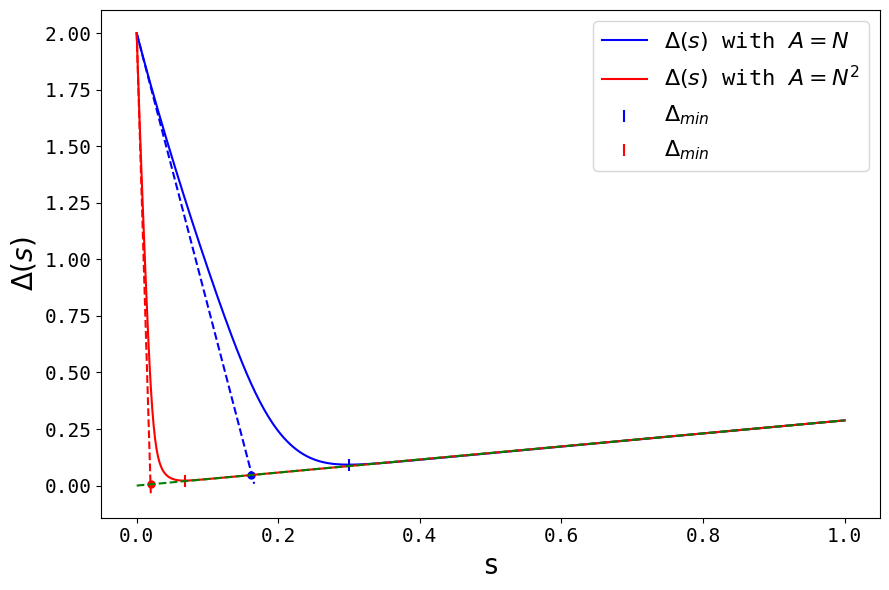

In [11]:
plt.figure(figsize=(9,6))

ns = 3
f = h5py.File(f"data/ex/gapN2.jld", "r")

S, D, D2 = np.array(f["S"]), np.array(f["D"]), np.array(f["D2"])
N, df = int(np.array(f["N"])), float(np.array(f["df"]))

plt.plot(S, D, c="blue", label="$\Delta(s)$ with $A=N$", aa=True)
plt.plot(S, D2, c="red", label="$\Delta(s)$ with $A=N^2$", aa=True)
plt.scatter([S[np.argmin(D)]], [D[np.argmin(D)]], marker="|", c="blue", s=85, label="$\Delta_{min}$")

sc_ind = np.argmin(np.abs(2 - (N+2)*S - df*S))
plt.plot(S[:sc_ind+3], 2 - (N+2)*S[:sc_ind+3], c="blue", ls="--", zorder=-1)
plt.scatter([S[np.argmin(D2)]], [D2[np.argmin(D2)]], marker="|", c="red", s=85, label="$\Delta_{min}$")
plt.scatter([S[sc_ind]], [df*S[sc_ind]], c="blue", s=25, zorder=1, alpha=1)

sc_ind = np.argmin(np.abs(2 - (N**2+2)*S) - df*S)
plt.plot(S[:sc_ind+1], 2 - (N**2+2)*S[:sc_ind+1], c="red", ls="--", zorder=-1)
plt.scatter([S[sc_ind]], [df*S[sc_ind]], c="red", s=25, zorder=1, alpha=1)

plt.plot(S[sc_ind-10:], df*S[sc_ind-10:], c="green", ls="--")

# plt.arrow(S[np.argmin(D)]+0.02, D[np.argmin(D)]-0.04, S[sc_ind]-S[np.argmin(D)], df*S[sc_ind]-D[np.argmin(D)], 
#           length_includes_head=True, head_width=0.015, width=0.005, head_starts_at_zero=True, aa=True, color="brown")

plt.legend(prop={'size': 16})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.ylabel("$\\Delta(s)$", fontsize=20)

plt.tight_layout()
plt.savefig("plots/gapN2.pdf", bbox_inches="tight"))

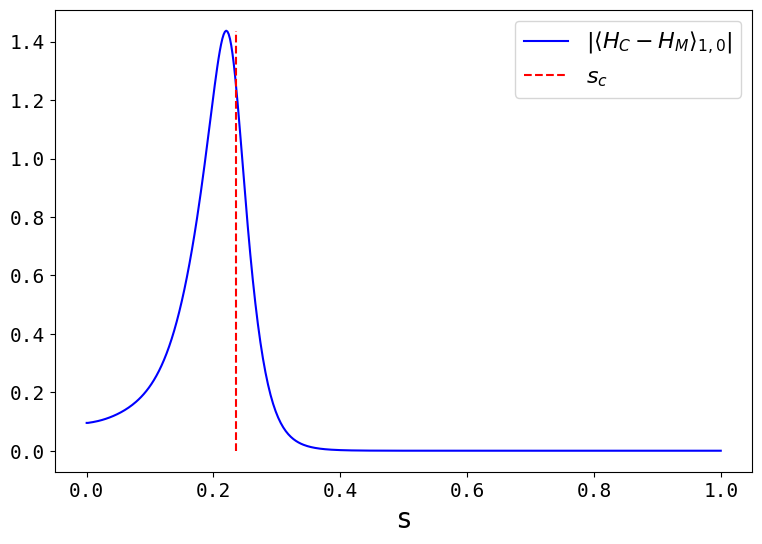

In [167]:
plt.figure(figsize=(9,6))

f = h5py.File(f"data/ex/ex_dH.jld", "r")

S, dH = np.array(f["S"]), np.array(f["dH"])
sc = float(np.array(f["sc"]))

plt.plot(S, dH, c="blue", label="$| \\langle H_C - H_M \\rangle_{1, 0} | $", aa=True)
plt.vlines([sc], 0, np.max(dH), label="$s_c$", color="red", ls="--")

plt.legend(prop={'size': 16})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.savefig("plots/ex_dH.pdf", bbox_inches="tight")

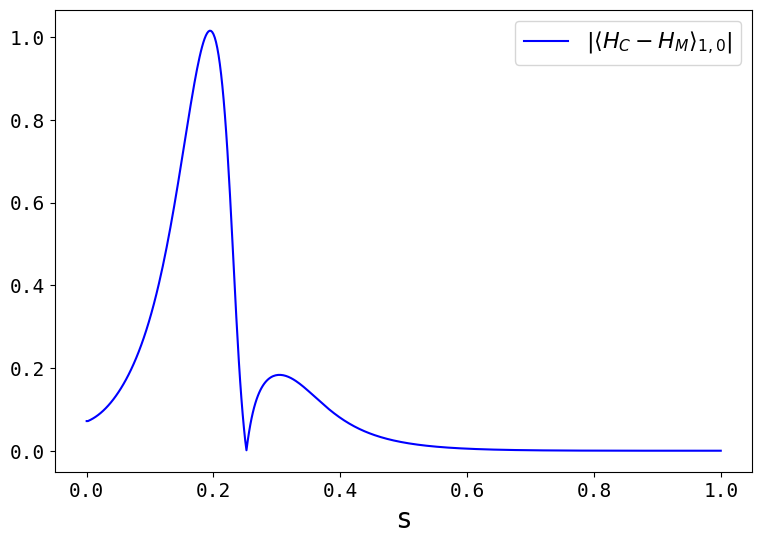

In [13]:
plt.figure(figsize=(9,6))

f = h5py.File(f"data/ex/ex2_dH.jld", "r")

S, dH = np.array(f["S"]), np.array(f["dH"])

plt.plot(S, dH, c="blue", label="$| \\langle H_C - H_M \\rangle_{1, 0} | $", aa=True)

plt.legend(prop={'size': 16})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.savefig("plots/ex2_dH.pdf")

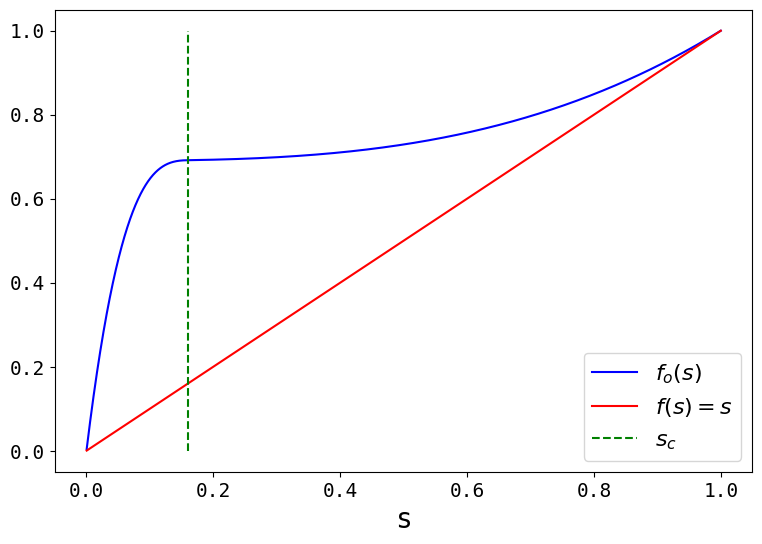

In [169]:
plt.figure(figsize=(9,6))

f = h5py.File(f"data/ex/ex_fs.jld", "r")

S, fo, To = np.array(f["S"]), np.array(f["f"]), float(np.array(f["T"]))

df = 0.5
N = 10

plt.plot(S, fo*To/N, c="blue", label="$f_o(s)$", aa=True)
plt.plot(S, S, c="red", label="$f_{}(s) = s$", aa=True)
plt.vlines([2/(2+df+N)], 0, 1, color="green", label="$s_c$", ls="--")
plt.legend(prop={'size': 16}, loc="lower right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("s", fontsize=20)
plt.savefig("plots/ex_fs.pdf", bbox_inches="tight")

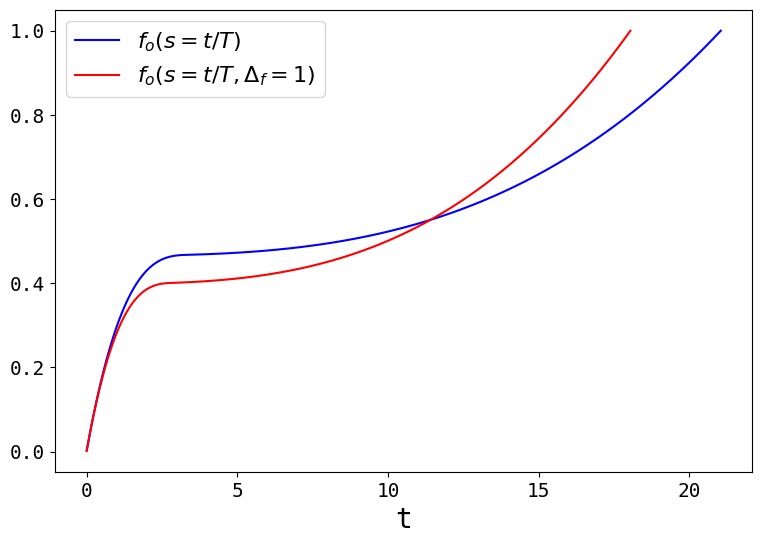

In [183]:
plt.figure(figsize=(9,6))

f = h5py.File(f"data/ex/ex_fs.jld", "r")

S, fo, S1, fo1 = np.array(f["S"]), np.array(f["f"]), np.array(f["S1"]), np.array(f["f1"])
To, To1 = float(np.array(f["T"])), float(np.array(f["T1"]))

N = 10

plt.plot(S*To, fo*To/N, c="blue", label="$f_o(s = t/T)$", aa=True)
plt.plot(S1*To1, fo1*To1/N, c="red", label="$f_o(s = t/T, \Delta_f = 1)$", aa=True)

plt.legend(prop={'size': 16})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("t", fontsize=20)
plt.savefig("plots/fs_compared.pdf", bbox_inches="tight")

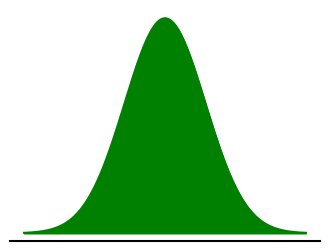

In [158]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(4,3))
x = np.linspace(0, 1, 1000)
ax.plot(x, norm.pdf(x, 0.5, 1/7), c="g")
ax.fill_between(x, norm.pdf(x, 0.5, 1/7), color='g')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([-0.1, 2.9])

ax.spines['bottom'].set_linewidth(1.5)
# ax.spines['left'].set_linewidth(1.5)

plt.savefig("plots/gauss.png", transparent=True)

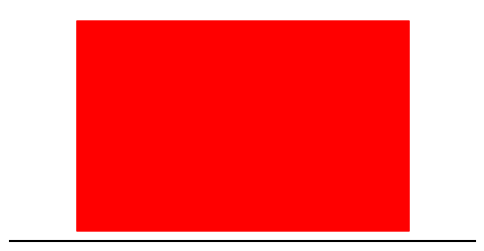

In [160]:
fig, ax = plt.subplots(figsize=(6,3))
x = np.linspace(0, 1, 1000)
ax.fill_between(x, [1]*1000, color="r")
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.set_ylim([-0.05, 1.5])
ax.set_xlim([-0.2, 1.2])
ax.spines['bottom'].set_linewidth(1.5)
# ax.spines['left'].set_linewidth(1.5)

plt.savefig("plots/uniform.png", transparent=True)